In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import (cross_val_score, StratifiedKFold)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

### Model Eval w/ Decision Tree

In [3]:
dogs_train = pd.read_csv('dogs_train.csv')
X_train = dogs_train.drop(['IsOldPet', 'Breed', 'Gender', 'Neutered', 'Age segment', 'BreedGroupId'], axis = 1)
y_train = dogs_train['BreedGroupId']

dogs_test = pd.read_csv('dogs_test.csv')
X_test = dogs_test.drop(['IsOldPet', 'Breed', 'Gender', 'Neutered', 'Age segment', 'BreedGroupId'], axis = 1)
y_test = dogs_test['BreedGroupId']

In [4]:
tree_model = DecisionTreeClassifier(criterion = "gini", min_impurity_decrease = .001, min_samples_leaf = 5, max_depth = 2, max_features = None)
tree_model.fit(X_train, y_train)
predictions = tree_model.predict(X_test)

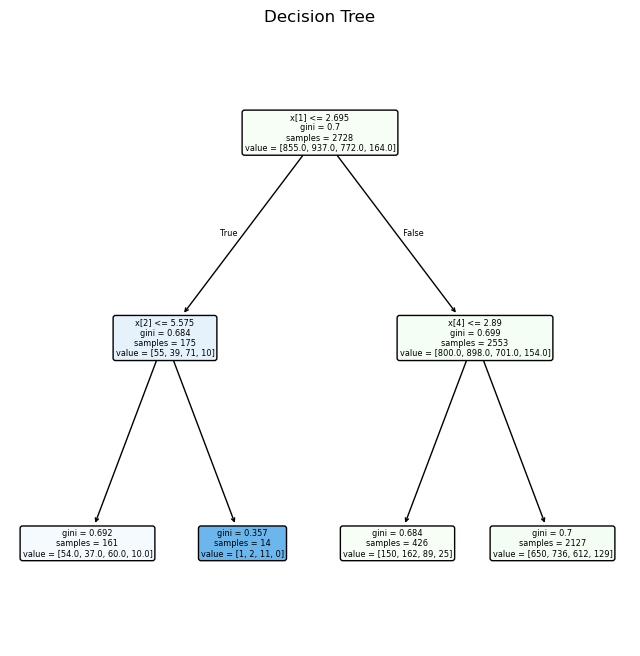

In [5]:
plt.figure(figsize = (8, 8))
plot_tree(tree_model, filled = True, rounded = True)
plt.title("Decision Tree")
plt.show()

In [6]:
print('Confusion Matrix = \n', confusion_matrix(y_test, predictions))
print('Accuracy =', accuracy_score(y_test, predictions))
print('Precision =', precision_score(y_test, predictions, average = 'macro'))
print('Recall =', recall_score(y_test, predictions, average = 'macro'))
print('F1 score =', f1_score(y_test, predictions, average = 'macro'))
print("AUC (OVR):", roc_auc_score(y_test, tree_model.predict_proba(X_test), multi_class='ovr'))

Confusion Matrix = 
 [[  0 198  24   0]
 [  0 223  15   0]
 [  0 175  11   0]
 [  0  36   1   0]]
Accuracy = 0.34260614934114203
Precision = 0.14213359394390668
Recall = 0.24902864371555072
F1 score = 0.1513676705950822
AUC (OVR): 0.4971513395306485


### Cross-Validation

In [7]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X = X, y = y, groups = None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c = indices, marker = '_', lw = lw, cmap = cmap_cv,
                   vmin = -.2, vmax = 1.2)
        
    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c = y, marker = '_', lw = lw, cmap = cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks = np.arange(n_splits + 1) + .5, yticklabels = yticklabels,
           xlabel = 'Sample index', ylabel = "CV iteration",
           ylim = [n_splits + 1.2, -.1], xlim = [0, X.shape[0]])
    ax.set_title('{}'.format(type(cv).__name__), fontsize = 15)
    return ax

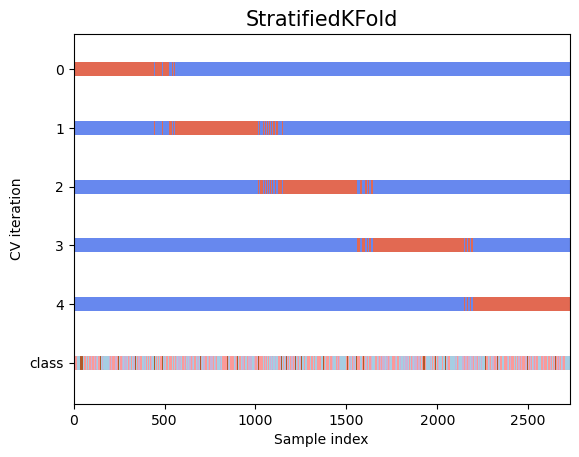

In [8]:
n_splits = 5
cv = StratifiedKFold(n_splits)

fig, ax = plt.subplots()
plot_cv_indices(cv, X_train, y_train, ax, n_splits)
plt.show()

In [9]:
scores = cross_val_score(tree_model, X_train, y_train, cv = 5)
scores

array([0.33882784, 0.33516484, 0.35531136, 0.34495413, 0.31192661])

In [10]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.34 accuracy with a standard deviation of 0.01


### Parameter Selection

In [11]:
param_dist  = {
              'ccp_alpha': [1, 0.5, 0.1],
              'max_depth' : [1, 2, 3],
              'criterion' :['gini', 'entropy'],
              'min_impurity_decrease' : [0.0005, 0.001, 0.005]
             }

In [12]:
model = DecisionTreeClassifier()
tree_cv = GridSearchCV(model, param_dist, cv = 5)

tree_cv.fit(X_train, y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'ccp_alpha': 1, 'criterion': 'gini', 'max_depth': 1, 'min_impurity_decrease': 0.0005}
Best score is 0.3434754847598884


### Model Selection

In [13]:
models_list = [LogisticRegression(max_iter = 100), SVC(), DecisionTreeClassifier()]

model_hyperparameters = {
    'log_reg_hyperparameters': {        
        'C' : [1, 5, 10, 20] },

    'svc_hyperparameters': {        
        'kernel' : ['linear','poly','rbf','sigmoid'],
        'C' : [1, 2, 3, 4, 5] },

    'random_forest_hyperparameters' : {        
        'criterion' :['gini', 'entropy'],
         'max_depth' : [1, 2, 3] }
}

model_keys = list(model_hyperparameters.keys())

In [14]:
def ModelSelection(list_of_models, hyperparameters_dictionary, random = False):

  result = []

  i = 0

  for model in list_of_models:

    key = model_keys[i]

    params = hyperparameters_dictionary[key]

    i += 1

    print(model)
    print(params)
    print('---------------------------------')


    if random:
        classifier = RandomizedSearchCV(model, params, cv = 5)
    else:
        classifier = GridSearchCV(model, params, cv = 5)
    # fitting the data to classifier
    classifier.fit(X_train, y_train)

    result.append({
        'model used' : model,
        'highest score' : classifier.best_score_,
        'best hyperparameters' : classifier.best_params_
    })

  result_dataframe = pd.DataFrame(result, columns = ['model used', 'highest score', 'best hyperparameters'])

  return result_dataframe

In [ ]:
ModelSelection(models_list, model_hyperparameters)

LogisticRegression()
{'C': [1, 5, 10, 20]}
---------------------------------
SVC()
{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 2, 3, 4, 5]}
---------------------------------


In [ ]:
ModelSelection(models_list, model_hyperparameters, random = True)